In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
filter0, filter1, weight0, bias0, loss_training_set ,loss_test_set = CNN()

0.0 % proceeding
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------[[  4.94433685   0.04137146]
 [ -5.78303531 -25.75520418]] [[  1.14944205   2.44013671  -4.59932328]
 [ 20.24954362  -0.62890586 -13.38398682]
 [  6.79403157 -18.03979232  -0.58239126]]


training loss is 8.003639884524588
test loss is 4.977614911653973
0.642 accuracy!
2.0 % proceeding
------------------------------------------------------------------------------------------------

In [10]:
confusionmatrix, top3matrix, top3matrix_index = ConfusionMatrix_n_top3(filter0, filter1, weight0, bias0, test_data)

# Loader

In [2]:
import gzip
import numpy as np
from pathlib import Path
import math
import random

class Dataloader():
    def __init__(self, path, is_train=True, shuffle=True, batch_size=8):
        path = Path(path)
        imagePath = Path(path/'train-images-idx3-ubyte.gz') if is_train else Path(path/'t10k-images-idx3-ubyte.gz')
        labelPath = Path(path/'train-labels-idx1-ubyte.gz') if is_train else Path(path/'t10k-labels-idx1-ubyte.gz')

        self.batch_size = batch_size
        self.images = self.loadImages(imagePath)
        self.labels = self.loadLabels(labelPath)
        self.index = 0
        self.idx = np.arange(0, self.images.shape[0])
        if shuffle: np.random.shuffle(self.idx) # shuffle images

    def __len__(self):
        n_images, _, _, _ = self.images.shape
        n_images = math.ceil(n_images / self.batch_size)
        return n_images

    def __iter__(self):
        return datasetIterator(self)

    def __getitem__(self, index):
        image = self.images[self.idx[index * self.batch_size:(index + 1) * self.batch_size]]
        label = self.labels[self.idx[index * self.batch_size:(index + 1) * self.batch_size]]
        image = image/255.0
        return image, label

    def loadImages(self, path):
        with gzip.open(path) as f:
            images = np.frombuffer(f.read(), 'B', offset=16)
            images = images.reshape(-1, 1, 28, 28).astype(np.float32)
            return images

    def loadLabels(self, path):
        with gzip.open(path) as f:
            labels = np.frombuffer(f.read(), 'B', offset=8)
            rows = len(labels)
            cols = labels.max() + 1
            one_hot = np.zeros((rows, cols)).astype(np.uint8)
            one_hot[np.arange(rows), labels] = 1
            one_hot = one_hot.astype(np.float64)
            return one_hot

# for enumerate magic python function returns Iterator
class datasetIterator():
    def __init__(self, dataloader):
        self.index = 0
        self.dataloader = dataloader

    def __next__(self):
        if self.index < len(self.dataloader):
            item = self.dataloader[self.index]
            self.index += 1
            return item
        # end of iteration
        raise StopIteration

# function

In [21]:
def ReLU(value):
    return max(0, value)

def converter_ReLU(array):
    return np.array([ReLU(x) for x in array])

def converter_ReLU_2D(array):
    return np.array([converter_ReLU(x) for x in array])

def zeroorone(value):
    if value > 0:
        return 1
    else:
        return 0
    
def converter_zeroorone_10(array):
    return np.array([zeroorone(x) for x in array.reshape(10)])

def converter_zeroorone_784(array):
    return np.array([zeroorone(x) for x in array.reshape(784)])

def converter_zeroorone(array):
    k = len(array.shape)
    n = 1
    for i in range(0,k):
        n = n*array.shape[i]
        #print(n)
    return np.array([zeroorone(x) for x in array.reshape(n)]).reshape(math.ceil(math.sqrt(n)),math.ceil(math.sqrt(n)))

def SoftMax(z):
    c = np.max(z)
    exp_z = np.exp(z-c)
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y

def Conv(array, filter):
    filter = np.flipud(np.fliplr(filter))
    sub_matrices = np.lib.stride_tricks.as_strided(array,shape = tuple(np.subtract(array.shape, filter.shape))+filter.shape, strides = array.strides * 2)
    return np.einsum('ij,klij->kl', filter, sub_matrices)

def Cross_entrophy_loss(y_label, y_prediction):
    return -np.sum(y_label*np.log(y_prediction+1e-7))

def Maxpooling(array):
    n = array.shape[0]
    m = math.ceil(n/2)
    MAX_array = np.zeros(m*m).reshape(m,m)
    MAX_array_indexed = np.zeros(n*n).reshape(n,n)
    for i in range(0,m):
        for j in range(0,m):
            new_array = array[2*i:2*i+2,2*j:2*j+2]
            MAX_array[i][j] = new_array.max()
            Index = (np.where(new_array==new_array.max())[0][0],np.where(new_array==new_array.max())[1][0])
            MAX_array_indexed[2*i+Index[0]][2*j+Index[1]] = 1
    return MAX_array,MAX_array_indexed

def rotate_180(m): 
    N = len(m) 
    ret = [[0] * N for _ in range(N)] 
    for r in range(N): 
        for c in range(N): 
            ret[N-1-r][N-1-c] = m[r][c] 
    return ret

In [4]:
def CNN(batchsize=100, epoch=50, testing = 1000):
    #ready for dataset
    learning_rate = batchsize/60000
    iteration = math.ceil(60000/batchsize)
    loss_training_set = []
    loss_test_set = []
    
    training_data = Dataloader(
        path="./",
        shuffle=True,
        batch_size=batchsize
    )
    test_data = Dataloader(
        path="./",
        shuffle=True,
        is_train = False,
        batch_size = 1
    )
    
    #initialize function
    filter0 = np.random.randn(2,2)*10
    filter1 = np.random.randn(3,3)*10
    weight0 = np.random.randn(25,10) #수정해
    bias0 = np.random.randn(10)
    for k in range(0,epoch):
        print(100*(k/epoch),"% proceeding")
        training_loss = 0
        error = 0
        test_loss = 0
        for i in range(0,iteration):
        #foward porpagation
            print("-",end='')
            delta_3 = 0
            chain_delta_3 = np.zeros(250).reshape(25,10) #수정해
            chain_delta_2 = np.zeros(9).reshape(3,3)
            chain_delta_1 = np.zeros(4).reshape(2,2)
            
            for j in range(0, batchsize):
                delta_1_b = 0
                delta_2_b = 0
                delta_3_b = 0
                chain_delta_3_b = np.zeros(250).reshape(25,10) #수정해
                chain_delta_2_b = np.zeros(9).reshape(3,3)
                chain_delta_1_b = np.zeros(4).reshape(2,2)

                y_label = training_data.__getitem__(i)[1][j]
                #layer 0 foward propagation
                layer_0 = training_data.__getitem__(i)[0][j].reshape(28,28) #28,28
                layer_0_conv = Conv(layer_0,filter0) #26*26
                #print(layer_0_conv.shape)
                layer_0_relu = converter_ReLU_2D(layer_0_conv) #26*26
                layer_0_pooling,layer_0_pooling_index = Maxpooling(layer_0_relu) #13*13,26*26
                #layer 1 foward propagation
                layer_1_conv = Conv(layer_0_pooling,filter1) #10*10
                layer_1_relu = converter_ReLU_2D(layer_1_conv) #10*10
                layer_1_pooling,layer_1_pooling_index = Maxpooling(layer_1_relu) #5*5,10*10
                #layer 2 foward propagation
                layer_2 = layer_1_pooling.reshape(25)
                layer_2_weight = np.dot(layer_2, weight0) + bias0
                layer_2_softmax = SoftMax(layer_2_weight)
                training_loss += Cross_entrophy_loss(y_label,layer_2_softmax)
                
                #layer 2 backward propagation
                delta_3_b = ((layer_2_softmax - y_label))/batchsize #batchsize
                chain_delta_3_b = np.dot(layer_2.reshape(25,1), delta_3_b.reshape(1,10))
                
                #layer 1 backward propagation
                delta_2_b = (((np.dot(weight0,delta_3_b).reshape(5,5)).repeat(2, axis=0)).repeat(2, axis=1))*layer_1_pooling_index*converter_zeroorone(layer_1_conv)
                chain_delta_2_b = Conv(layer_0_pooling,rotate_180(delta_2_b))
                #print(chain_delta_2_b.shape)
                
                #layer 0 backward propagation
                delta_1_b = Conv(np.pad(delta_2_b, ((3,3),(3,3)), 'constant', constant_values=0),filter1).reshape(13,13).repeat(2, axis=0).repeat(2, axis=1)*layer_0_pooling_index*converter_zeroorone(layer_0_conv)
                
                chain_delta_1_b = Conv(layer_0,rotate_180(delta_1_b))
                
                
                #update value
                delta_3 += delta_3_b
                chain_delta_3 += chain_delta_3_b
                chain_delta_2 += chain_delta_2_b
                chain_delta_1 += chain_delta_1_b
            weight0 -= (learning_rate * chain_delta_3)
            filter1 -= (learning_rate * chain_delta_2)
            filter0 -= (learning_rate * chain_delta_1)
            bias0 -= delta_3.reshape(10)*learning_rate
            #print(filter1,filter0)
        print(filter0,filter1)
        print("\n")
        print("training loss is",training_loss/60000)
        loss_training_set.append(training_loss/60000)
        
        for i in range(0,testing):
            y_label = test_data.__getitem__(i)[1]
            #layer 0 foward propagation
            layer_0 = test_data.__getitem__(i)[0].reshape(28,28) #28,28
            layer_0_conv = Conv(layer_0,filter0) #26*26
            #print(layer_0_conv.shape)
            layer_0_relu = converter_ReLU_2D(layer_0_conv) #26*26
            layer_0_pooling,layer_0_pooling_index = Maxpooling(layer_0_relu) #13*13,26*26
            #layer 1 foward propagation
            layer_1_conv = Conv(layer_0_pooling,filter1) #10*10
            layer_1_relu = converter_ReLU_2D(layer_1_conv) #10*10
            layer_1_pooling,layer_1_pooling_index = Maxpooling(layer_1_relu) #5*5,10*10
            #layer 2 foward propagation
            layer_2 = layer_1_pooling.reshape(25)
            layer_2_weight = np.dot(layer_2, weight0) + bias0
            layer_2_softmax = SoftMax(layer_2_weight)
            test_loss += Cross_entrophy_loss(y_label,layer_2_softmax)
            if(np.argmax(layer_2_softmax)!=np.argmax(test_data.__getitem__(i)[1])):
                error += 1
        print("test loss is",test_loss/testing)
        print(1-(error/testing),"accuracy!")
        loss_test_set.append(test_loss/testing)
    return filter0, filter1, weight0, bias0, loss_training_set ,loss_test_set

In [6]:
test_data = Dataloader(
    path="./",
    shuffle=True,
    is_train = False,
    batch_size = 1
)

In [8]:
def ConfusionMatrix_n_top3(filter0, filter1, weight0, bias0, test_data):
    confusionmatrix = np.zeros(100).reshape(10,10)
    top3matrix = np.zeros(30).reshape(10,3)
    top3matrix_index = np.zeros(30).reshape(10,3)
    for i in range(0,10000):
        y_label = test_data.__getitem__(i)[1]
        #layer 0 foward propagation
        layer_0 = test_data.__getitem__(i)[0].reshape(28,28) #28,28
        layer_0_conv = Conv(layer_0,filter0) #26*26
        #print(layer_0_conv.shape)
        layer_0_relu = converter_ReLU_2D(layer_0_conv) #26*26
        layer_0_pooling,layer_0_pooling_index = Maxpooling(layer_0_relu) #13*13,26*26
        #layer 1 foward propagation
        layer_1_conv = Conv(layer_0_pooling,filter1) #10*10
        layer_1_relu = converter_ReLU_2D(layer_1_conv) #10*10
        layer_1_pooling,layer_1_pooling_index = Maxpooling(layer_1_relu) #5*5,10*10
        #layer 2 foward propagation
        layer_2 = layer_1_pooling.reshape(25)
        layer_2_weight = np.dot(layer_2, weight0) + bias0
        layer_2_softmax = SoftMax(layer_2_weight)
        y_prediction = layer_2_softmax
        
        #confusionmatrix
        confusionmatrix[np.argmax(y_label)][np.argmax(y_prediction)]+=1
        index = np.argmin(top3matrix[np.argmax(y_prediction)])
        if top3matrix[np.argmax(y_prediction)][index] <= y_prediction[np.argmax(y_prediction)]:
            top3matrix[np.argmax(y_prediction)][index] =  y_prediction[np.argmax(y_prediction)]
            top3matrix_index[np.argmax(y_prediction)][index] = i
            
    return confusionmatrix , top3matrix, top3matrix_index

# Loss graph

In [13]:
index = [x for x in range(50)]

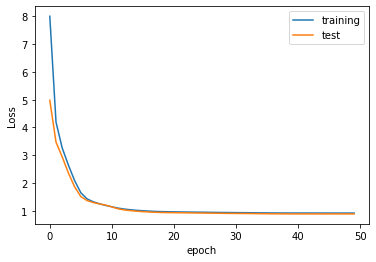

In [14]:
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(index,loss_training_set)
plt.plot(index,loss_test_set)
plt.legend(['training', 'test'])
plt.show()

# Confusion Matrix

In [15]:
confusionmatrix_visualization = np.array([(100*x)/np.sum(x) for x in confusionmatrix])

In [16]:
confusionmatrix_visualization = np.array([ np.fix(x) for x in confusionmatrix])

In [17]:
confusionmatrix_visualization.astype(int)

array([[ 749,    0,   16,   13,    7,  100,   26,   43,    4,   22],
       [   1, 1075,   10,    2,    4,   10,    1,    0,   11,   21],
       [  17,   15,  757,   45,    2,   19,   31,   43,   81,   22],
       [  20,   10,   52,  650,    1,  155,   24,   22,   30,   46],
       [  17,   17,   30,    7,  559,   31,   91,   34,   36,  160],
       [  16,    8,   28,   65,    6,  620,   17,   49,   42,   41],
       [  37,    9,   33,    6,   24,   29,  614,   34,   24,  148],
       [  11,   13,   55,    8,   12,    7,    9,  674,   18,  221],
       [   7,   22,   40,   23,    9,   74,   22,   31,  660,   86],
       [  10,    3,    9,    8,    9,   19,   19,   83,   32,  817]])

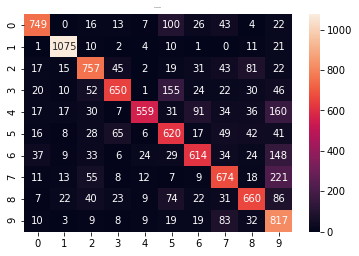

In [18]:
sns.heatmap(confusionmatrix_visualization.astype(int), annot=True, fmt='d')

plt.title('confusionmatrix', fontsize=1)

plt.show()

# Top-3 images with probability

In [20]:
print(top3matrix)

[[0.99481065 0.9985179  0.99343434]
 [0.99789017 0.99818423 0.99817173]
 [0.99993893 0.99995042 0.99995912]
 [0.98797295 0.98717337 0.98916809]
 [0.9996782  0.99968892 0.99941684]
 [0.99863    0.99947199 0.99863329]
 [0.99994764 0.99979571 0.99979019]
 [0.99682825 0.9966656  0.99590167]
 [0.99964454 0.99972902 0.99952306]
 [0.99807871 0.99715717 0.99810951]]


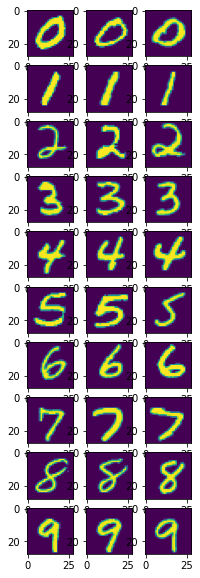

In [19]:
fig, axes = plt.subplots(10,3, figsize=(3,10))
j=0
for i,ax in enumerate(axes.flat):
    index = math.ceil(top3matrix_index.reshape(30)[j])
    ax.imshow(test_data.__getitem__(index)[0].reshape(28,28))
    j+=1